In [1]:
# %matplotlib tk

In [277]:
# Imports
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import folium
import geopandas as gpd
from shapely.geometry import Point
from shapely import Polygon
from folium.raster_layers import ImageOverlay
import io
import base64


# from descartes import PolygonPatch
# from matplotlib.cm import ScalarMappable
# from matplotlib.colors import Normalize, BoundaryNorm
# from matplotlib.collections import PolyCollection  
# from matplotlib.patches import Polygon
import zarr
from mpl_toolkits.basemap import Basemap
plt.style.use('seaborn-v0_8')



from shapely.geometry import Polygon
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import PatchCollection
from matplotlib.collections import PatchCollection

In [3]:
""" Load 4D ERA5 data as xarray.core.dataset.Dataset from $DATA

Some important properties
    Latitude 
        Range [44.23337936401367, 46.7599983215332] degrees North
    Longitude
        Range [-75.53164672851562, -71.8677978515625] degrees East
    Rotated Pole
        longitude, latitude [-73.57501220703125,45.5]
    Time scales:
        tas  - hourly
        tmax - daily
        q    - 3 hourly 
"""
# without TEB
tas_n = xr.open_zarr('/runoff/gulley/St_Laurent/StLaurent_1km_SL2.5_ERA5_advHU/tas.zarr')      
tmax_n= xr.open_zarr('/runoff/gulley/St_Laurent/StLaurent_1km_SL2.5_ERA5_advHU/tasmax.zarr')
qn = xr.open_zarr('/runoff/gulley/St_Laurent/StLaurent_1km_SL2.5_ERA5_advHU/huss.zarr')

# with TEB
tas_t = xr.open_zarr('/runoff/gulley/St_Laurent/StLaurent_1km_SL2.5_ERA5_advHU_TEB/tas.zarr')
tmax_t= xr.open_zarr('/runoff/gulley/St_Laurent/StLaurent_1km_SL2.5_ERA5_advHU_TEB/tasmax.zarr')
qt = xr.open_zarr('/runoff/gulley/St_Laurent/StLaurent_1km_SL2.5_ERA5_advHU_TEB/huss.zarr')

# static fields
static_fields = xr.open_mfdataset('/runoff/gulley/St_Laurent/StLaurent_1km_SL2.5_ERA5_advHU_step0.nc')
urban_fraction_2d = static_fields['furban'].isel(lev=5)
lons = static_fields.lon.values
lats = static_fields.lat.values

# To account for the issue in the simulation in 2022, a slice of each dataset is loaded
tas_n = tas_n.sel(time=slice('2021'))     
tmax_n= tmax_n.sel(time=slice('2021'))
qn = qn.sel(time=slice('2021'))

# # with TEB
tas_t = tas_t.sel(time=slice('2021'))     
tmax_t= tmax_t.sel(time=slice('2021'))
qt = qt.sel(time=slice('2021'))

In [4]:
# To get the relative humidity we need to:
# Divide the absolute humidity for each simiulation by the saturation vapour pressure at each 

In [5]:
# Load ECCC_AHCCD_gen3_temperature data for stations in Canada
pavics = xr.open_dataset("https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/station_obs/ECCC_AHCCD_gen3_temperature.ncml")

# Restrict the selection by masking for only stations within the domain
station_is_in_domain = (
    (pavics.lat>44.23337936401367)    & 
    (pavics.lat <46.7599983215332)    & 
    (pavics.lon > -75.53164672851562) & 
    (pavics.lon < -71.8677978515625)
)

# Set the stations into a pandas dataframe
stations = pavics.sel(station=station_is_in_domain).set_coords(['lat', 'lon', 'station_name'])

In [6]:
# Map formatting properties for field projection
# bbox = [[44.23337936401367, -75.53164672851562], [46.7599983215332, -71.8677978515625]]

lat_min = min(lats.flatten())
lat_max = max(lats.flatten())
lon_min = min(lons.flatten())
lon_max = max(lons.flatten())

centre_lat = (lat_min + lat_max) / 2
centre_lon = (lon_min + lon_max) / 2
bounds = [[lat_min, lon_min], [lat_max, lon_max]]
extent = [lon_min, lon_max, lat_min, lat_max]

# To project station data onto the map
gdf = pd.read_pickle('polygons_gdf.pkl')
patches = [MplPolygon(np.array(poly.exterior.coords), closed=True) for poly in gdf.geometry]

station_locations = stations[['lat', 'lon', 'station_name']].to_dataframe().reset_index()
geojson_stations = gpd.GeoDataFrame(
    station_locations, geometry=gpd.points_from_xy(station_locations['lon'], station_locations['lat'])
).to_json()

In [165]:
def show_colorbar(vmin=None,vmax=None,levels=10,cmap='bwr',orientation='horizontal'
                  ,layout='constrained',label=None,adjustment = 0.):
    # Creates a colour bar with discrete categories for map using matplotlib conventions
    
    fig,ax = plt.subplots(figsize=(7,1),layout=layout)
    cmap = plt.get_cmap(cmap)
    levels += 1
    if vmin == None: vmin = 0
    if vmax == None: vmax = 1
    bounds = np.linspace(vmin,vmax,levels) -  adjustment
    norm = BoundaryNorm(bounds, cmap.N)
    fig.colorbar(ScalarMappable(norm=norm, cmap=cmap),
                 cax=ax, orientation='horizontal', label=label)    

In [371]:
def draw_map(field=None,cmap_name='bwr',vmin=243.15,vmax=313.15,num_levels=None):
    """
    Creates a map and displays the station_locations within the bounds of the simulation on it. 
    It then generates an ImageOverlay of some the static field generated.
    Example usage:
        > f = tmax_n['tasmax'].sel(time='1999-03-08')
        > m = draw_map(f)
        > display(m)

    parameters:
        field - xarray.core.dataarray.DataArray
            2D temperature, humidity, or other data 
        cmap - string
            matplotlib colormap indicator
        vmin, vmax - float 
            minimum and maximum 
    returns:
        m - folium.folium.Map
    """
    
    # Initialize the map
    m = folium.Map(location=[centre_lat, centre_lon], zoom_start=8)

    folium.TileLayer("cartodb positron").add_to(m)

    # Add station markers
    folium.GeoJson(
        geojson_stations,
        popup=folium.GeoJsonPopup(fields=['station_name'], aliases=['Station Name']),
        marker=folium.CircleMarker(radius=3, color='grey', fill=True, fill_color='grey', fill_opacity=0.7)
    ).add_to(m)

    # Overlay field data
    if field is not None:
        # Create an image to store the field data
        image_buffer = io.BytesIO()

        # Field properties
        norm = Normalize(vmin=vmin, vmax=vmax)
        cmap = plt.get_cmap(cmap_name)  
        sm = ScalarMappable(cmap=cmap, norm=norm)
        
        # Create the figure to save to the map
        fig, ax = plt.subplots(figsize=(6, 6), dpi=800)
        
        bm = Basemap(projection='merc', 
            llcrnrlat=lat_min, 
            urcrnrlat=lat_max, 
            llcrnrlon=lon_min, 
            urcrnrlon=lon_max,ax=ax)

        # This works fine, but it inserts resolution where none should exist!
        # x, y = bm(lons, lats)
        # bm.contourf(x, y, field.values, cmap=cmap_name,vmin= vmin,vmax= vmax, levels=num_levels,antialiased=False)
        # XOR
        # bm.pcolormesh(x, y, field.values, cmap=cmap_name,vmin= vmin,vmax= vmax)
        
        flat_field = np.ravel(field.values)
        gdf["field"] = flat_field

        fig, ax = plt.subplots(figsize=(8, 8))
        collection = PatchCollection(
            patches,
            linewidth=0,
            edgecolor='none',
            antialiased=False
        )
        collection.set_array(gdf["field"].values)
        collection.set_cmap("coolwarm")
        
        
        ax.add_collection(collection)
        ax.autoscale_view()
        ax.set_aspect("equal")
        ax.axis("off")

        minx, miny, maxx, maxy = gdf.total_bounds
        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)
        
        # Force the canvas to layout everything
        # fig.canvas.draw()

        # Then save
        plt.savefig(image_buffer, format="png", bbox_inches="tight", pad_inches=0, transparent=True)


        
        ax.axis("off")  # Remove axes for clean image
        
        # Save image to buffer
        plt.savefig(image_buffer, format="png", bbox_inches="tight", pad_inches=0, transparent=True)
        plt.close(fig)
        plt.close()
        image_buffer.seek(0)
        image_base64 = base64.b64encode(image_buffer.read()).decode()
        image_uri = f"data:image/png;base64,{image_base64}"
        # Read image from buffer and project onto map
        ImageOverlay(
            image=image_uri,
            bounds=bounds,
            opacity=0.6,
            interactive=True,
            cross_origin=False,
            pixelated=True
        ).add_to(m)
        
    m.fit_bounds(bounds)
    return m

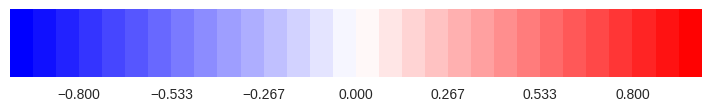

In [367]:
show_colorbar(vmin=-1,vmax=1,levels=30)

In [373]:
f = tmax_n['tasmax'].sel(time='1999-03-31')
m = draw_map(f,vmin=None,vmax=None)
m.save('/home/gulley/urban_heat_waves/tasmax_1999-03-31.html')
# display(m)

In [ ]:
f = urban_fraction_2d
m = draw_map(f,vmin=-1,vmax=1)
# m.save('/home/gulley/urban_heat_waves/tasmax_1999-03-31.html')
display(m)

In [ ]:
tmax_n_summer = tmax_n.groupby('time.season')['JJA']

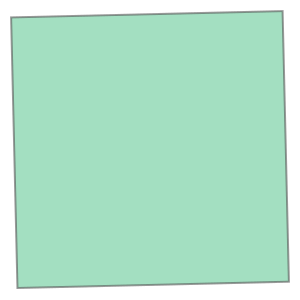

In [212]:
# # Load the polygon matrix
# with open('polygons_updated.pkl', 'rb') as f:
#     polygons_matrix = pickle.load(f)
# polygons_matrix

In [ ]:
# # Load the polygon matrix
# with open('polygons_updated.pkl', 'rb') as f:
#     polygons_matrix = pickle.load(f)
# polygons_matrix

In [263]:
# gdf.to_pickle("polygons_gdf.pkl")
# gdf = pd.read_pickle("polygons_gdf.pkl")

# gdf = gpd.GeoDataFrame(geometry=flat_polygons)

# # Plot the polygons
# gdf.plot(cmap='viridis', edgecolor='black')
# plt.show()

In [ ]:
# field = tmax_n['tasmax'].sel(time='1999-03-31')
# flat_field = np.ravel(field.values)
# gdf["field"] = flat_field

In [317]:
# coords = [np.array(poly.exterior.coords) for poly in gdf.geometry]

# with open("polygon_coords.pkl", "wb") as f:
#     pickle.dump(coords, f)

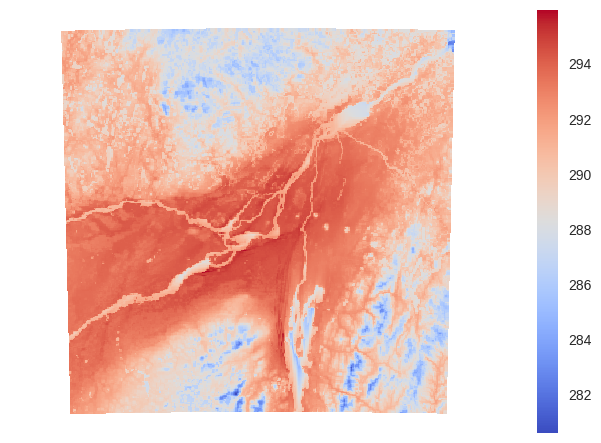

In [329]:


# from shapely.geometry import Polygon
# from matplotlib.patches import Polygon as MplPolygon
# from matplotlib.collections import PatchCollection

# # Convert Shapely to Matplotlib polygons
# patches = [MplPolygon(np.array(poly.exterior.coords), closed=True) for poly in gdf.geometry]

# fig, ax = plt.subplots()
# collection = PatchCollection(
#     patches,
#     linewidth=0,
#     edgecolor='none',
#     antialiased=False
# )
# collection.set_array(gdf["field"].values)
# collection.set_cmap("coolwarm")

# ax.add_collection(collection)
# ax.autoscale_view()
# plt.axis("equal")
# plt.axis("off")
# plt.colorbar(collection, ax=ax)
# plt.show()
